In [10]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats
import xarray as xr

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi'] = 300

# verison = "no_transform"
# version = "sqrt"
version = "transform_0.1"

test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_frames = torch.load(f"samples_{version}.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()

In [11]:
def psd_spatial(frames):
    fourier_image = np.fft.fftn(frames, axes = (1, 2))
    fourier_amplitudes = np.abs(fourier_image) ** 2

    npix = frames.shape[1]

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0] ** 2 + kfreq2D[1] ** 2)
    knrm = knrm.flatten()

    kbins = np.arange(0.5, npix // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic( 
        knrm,
        fourier_amplitudes.reshape(-1, npix * npix), 
        statistic = "mean",
        bins = kbins
    )
    Abins *= np.pi * (kbins[1:] ** 2 - kbins[:-1] ** 2)
    Abins = np.mean(Abins, axis = 0)

    return kvals, Abins

# kvals_test, Abins_test = psd_spatial(test_frames)
# kvals_sample, Abins_sample = psd_spatial(sample_frames)

# plt.figure(figsize=(6, 4))
# plt.loglog(kvals_test, Abins_test, label="UKCP18")
# plt.loglog(kvals_sample, Abins_sample, label="Generated")
# plt.xlabel("$k$")
# plt.ylabel("$P(k)$")
# plt.legend()
# plt.show()

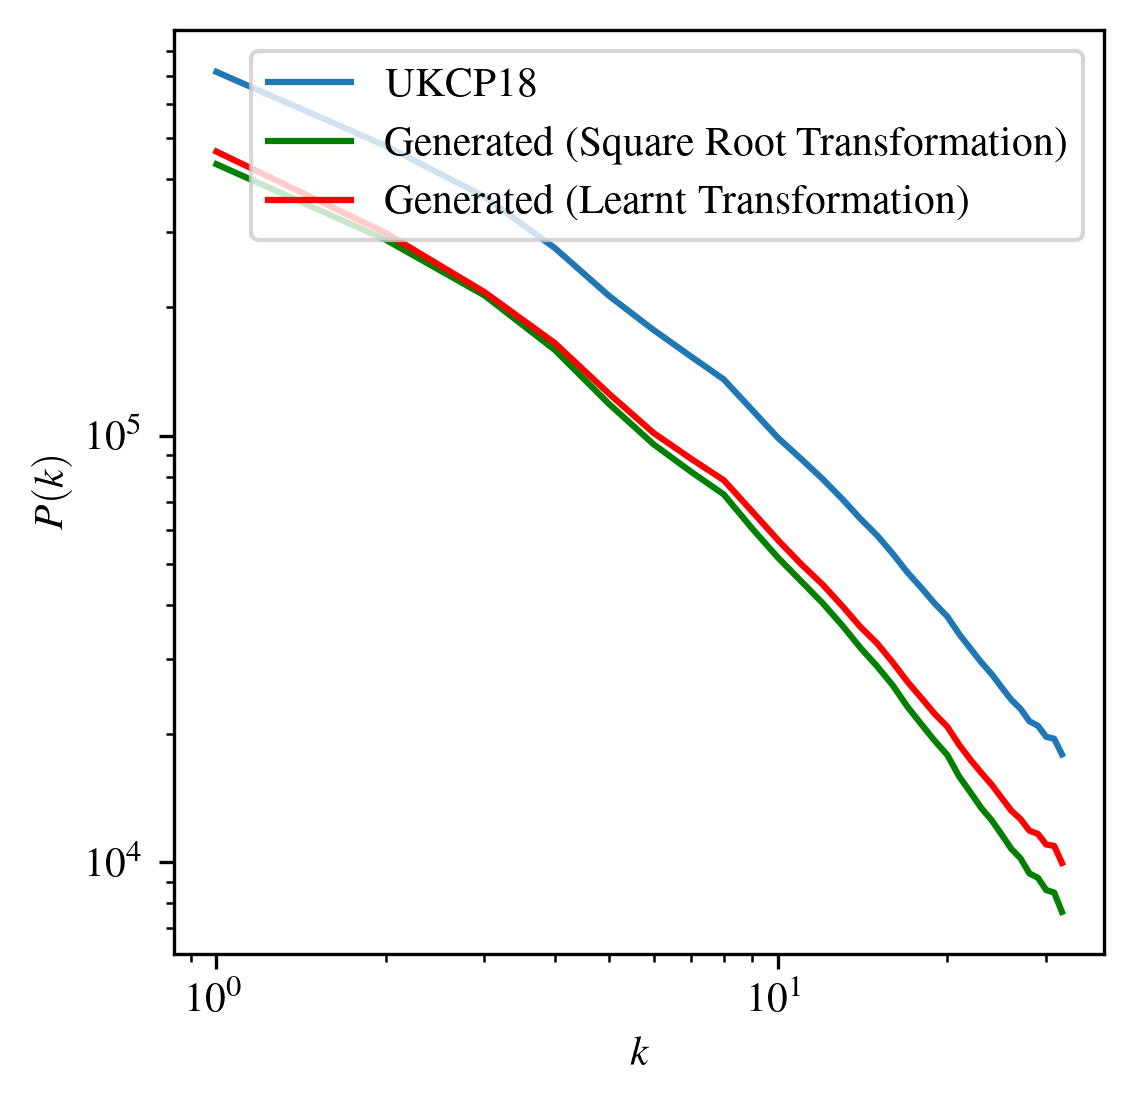

In [31]:
test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_sqrt_frames = torch.load(f"samples_sqrt.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()
sample_transform_frames = torch.load(f"samples_transform_0.1.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()

kvals_test, Abins_test = psd_spatial(test_frames)
kvals_sample_sqrt, Abins_sample_sqrt = psd_spatial(sample_sqrt_frames)
kvals_sample_transform, Abins_sample_transform = psd_spatial(sample_transform_frames)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_sqrt, Abins_sample_sqrt, label="Generated (Square Root Transformation)", c = "green")
plt.loglog(kvals_sample_transform, Abins_sample_transform, label="Generated (Learnt Transformation)", c = "red")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_spatial.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

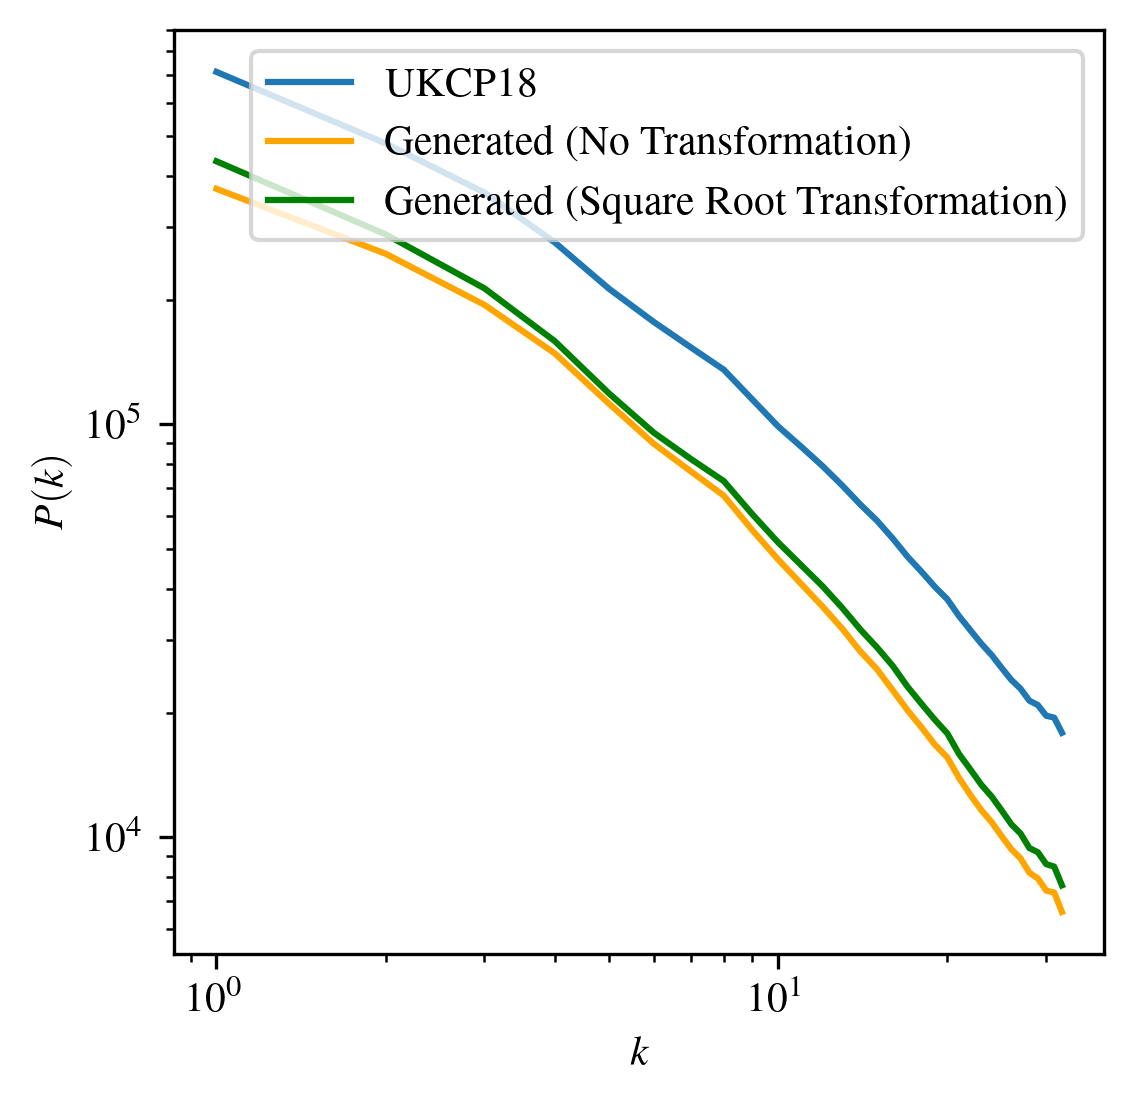

In [6]:
test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_no_transform_frames = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()
sample_sqrt_frames = torch.load(f"samples_sqrt.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()

kvals_test, Abins_test = psd_spatial(test_frames)
kvals_sample_no_transform, Abins_sample_no_transform = psd_spatial(sample_no_transform_frames)
kvals_sample_sqrt, Abins_sample_sqrt = psd_spatial(sample_sqrt_frames)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_no_transform, Abins_sample_no_transform, label="Generated (No Transformation)", c = "#ff7f0e")
plt.loglog(kvals_sample_sqrt, Abins_sample_sqrt, label="Generated (Square Root Transformation)", c = "green")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_spatial.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

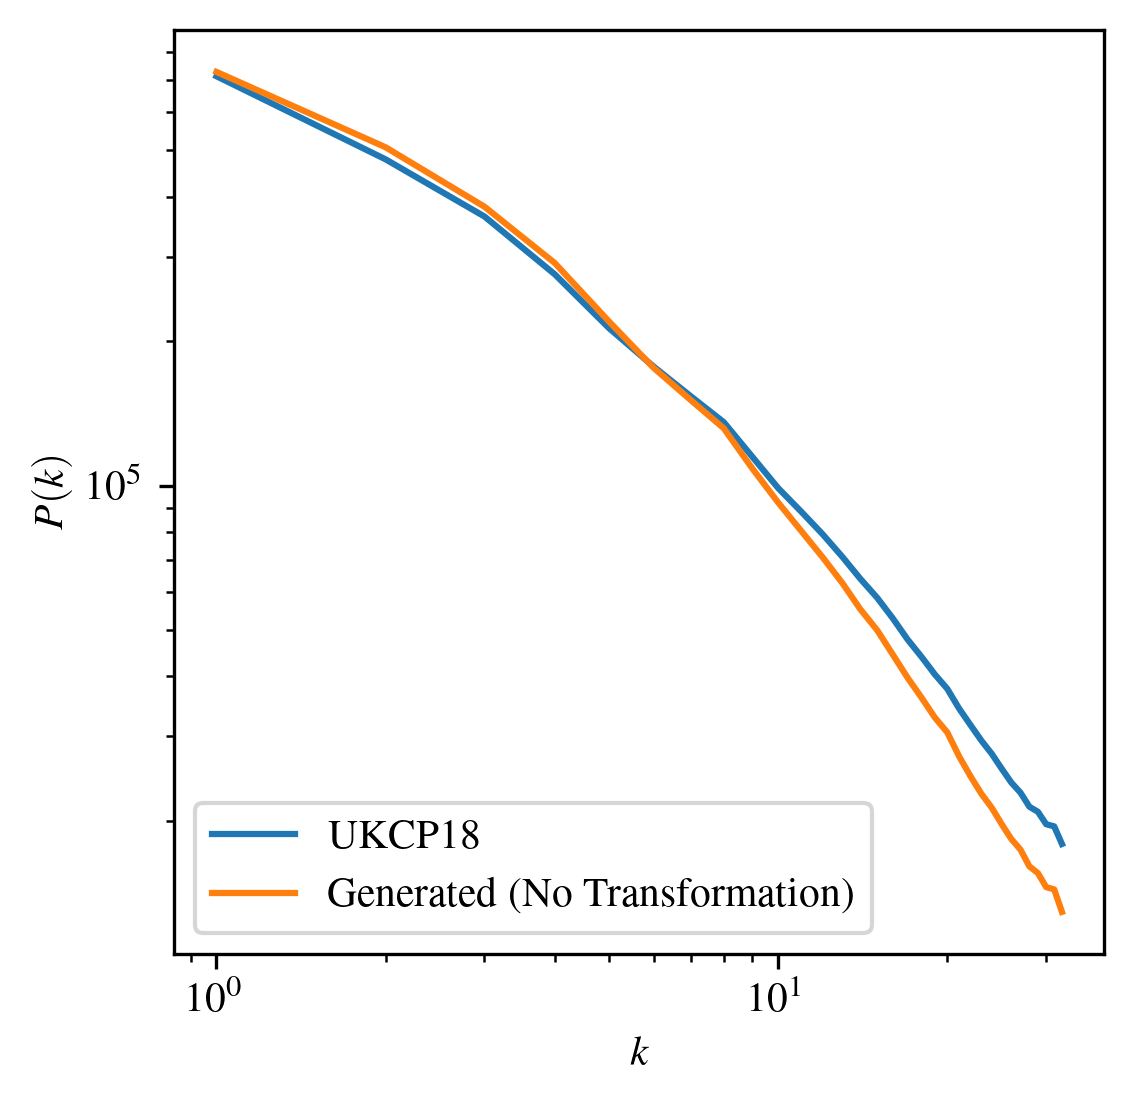

In [14]:
test_frames = xr.open_dataset("test.nc").pr.values.reshape(-1, 64, 64)
sample_no_transform_frames = torch.load(f"samples_no_transform.pt", map_location=torch.device('cpu')).reshape(-1, 64, 64).numpy()
kvals_test, Abins_test = psd_spatial(test_frames)
kvals_sample_no_transform, Abins_sample_no_transform = psd_spatial(sample_no_transform_frames)

plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_no_transform, Abins_sample_no_transform, label="Generated (No Transformation)", c = "#ff7f0e")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_spatial.png", bbox_inches="tight", pad_inches=0.02)
plt.show()

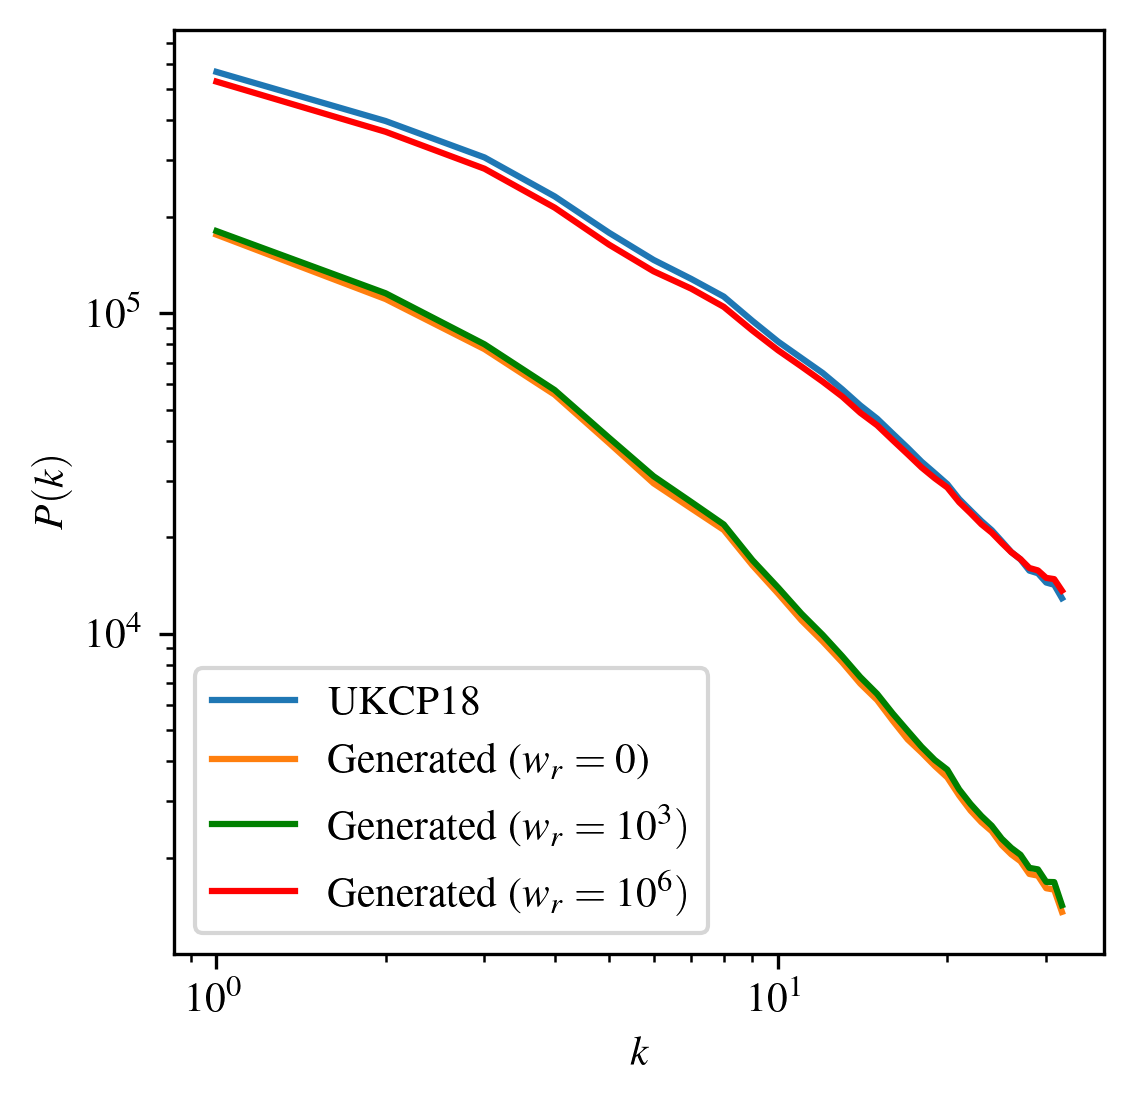

In [39]:
interpolate_0 = torch.load("cond_sample/cond_sample_recon_0.pt")
interpolate_1k = torch.load("cond_sample/cond_sample_recon_1000.pt")
interpolate_1m = torch.load("cond_sample/cond_sample.pt")

min_samples = min(interpolate_0.shape[0], interpolate_1k.shape[0], interpolate_1m.shape[0])
interpolate_0 = interpolate_0[:min_samples]
interpolate_1k = interpolate_1k[:min_samples]
interpolate_1m = interpolate_1m[:min_samples]

num_frames = interpolate_1m.shape[0] * 10

test = xr.open_dataset("test.nc").pr.isel(time = slice(0, num_frames)).values
test = test.reshape(-1, 1, 10, 64, 64)

indexes = [1, 3, 5, 7, 9]
# indexes = [0, 2, 4, 6, 8]
interpolate_0 = interpolate_0[:, 0, indexes, :, :]
interpolate_1k = interpolate_1k[:, 0, indexes, :, :]
interpolate_1m = interpolate_1m[:, 0, indexes, :, :]
test = test[:, 0, indexes, :, :]

interpolate_0 = interpolate_0.reshape(-1, 64, 64)
interpolate_1k = interpolate_1k.reshape(-1, 64, 64)
interpolate_1m = interpolate_1m.reshape(-1, 64, 64)
test = test.reshape(-1, 64, 64)

kvals_test, Abins_test = psd_spatial(test)
kvals_sample_interpolate_0, Abins_sample_interpolate_0 = psd_spatial(interpolate_0)
kvals_sample_interpolate_1k, Abins_sample_interpolate_1k = psd_spatial(interpolate_1k)
kvals_sample_interpolate_1m, Abins_sample_interpolate_1m = psd_spatial(interpolate_1m)


plt.figure(figsize=(4, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample_interpolate_0, Abins_sample_interpolate_0, label="Generated ($w_r = 0$)", c = "#ff7f0e")
plt.loglog(kvals_sample_interpolate_1k, Abins_sample_interpolate_1k, label="Generated ($w_r = 10^{3})$", c = "green")
plt.loglog(kvals_sample_interpolate_1m, Abins_sample_interpolate_1m, label="Generated ($w_r = 10^{6})$", c = "red")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.savefig("examples/psd_spatial.png", bbox_inches="tight", pad_inches=0.02)
plt.show()


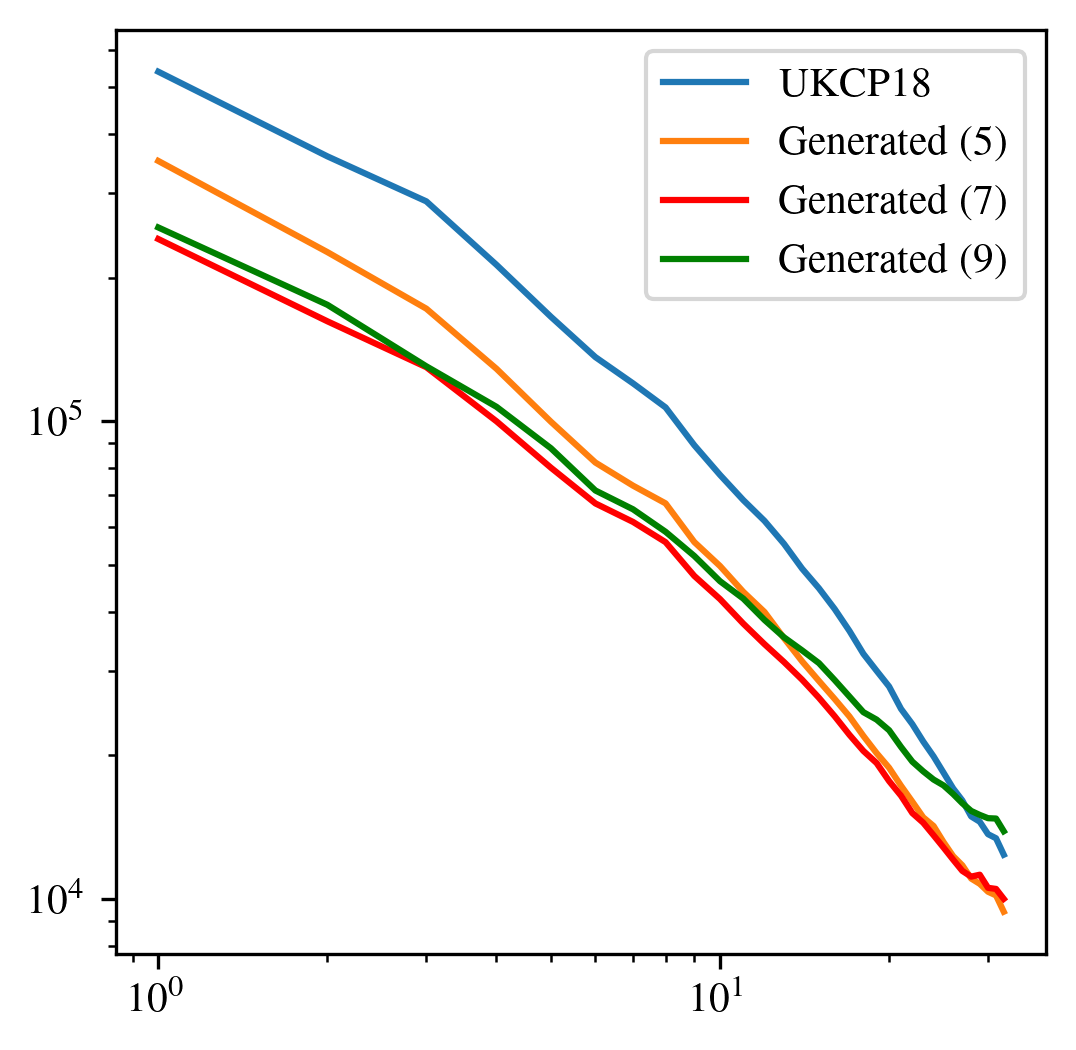

In [40]:
# !scp bp:predict.pt cond_sample/

predict = torch.load("cond_sample/predict.pt")

num_frames = predict.shape[0] * 10

test = xr.open_dataset("test.nc").pr.isel(time = slice(0, num_frames)).values
test = test.reshape(-1, 1, 10, 64, 64)

predict_5 = predict[:, 0, 5, :, :]
predict_6 = predict[:, 0, 6, :, :]
predict_7 = predict[:, 0, 7, :, :]
predict_8 = predict[:, 0, 8, :, :]
predict_9 = predict[:, 0, 9, :, :]
test = test[:, 0, [5, 6, 7, 8, 9], :, :]

predict_5 = predict_5.reshape(-1, 64, 64)
predict_6 = predict_6.reshape(-1, 64, 64)
predict_7 = predict_7.reshape(-1, 64, 64)
predict_8 = predict_8.reshape(-1, 64, 64)
predict_9 = predict_9.reshape(-1, 64, 64)
test = test.reshape(-1, 64, 64)
 
kvals_predict_5, Abins_predict_5 = psd_spatial(predict_5)
kvals_predict_6, Abins_predict_6 = psd_spatial(predict_6)
kvals_predict_7, Abins_predict_7 = psd_spatial(predict_7)
kvals_predict_8, Abins_predict_8 = psd_spatial(predict_8)
kvals_predict_9, Abins_predict_9 = psd_spatial(predict_9)
kvals_test, Abins_test = psd_spatial(test)

plt.figure(figsize=(4, 4))
plt.loglog()
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_predict_5, Abins_predict_5, label="Generated (5)", c = "#ff7f0e")
plt.loglog(kvals_predict_7, Abins_predict_7, label="Generated (7)", c = "red")
plt.loglog(kvals_predict_9, Abins_predict_9, label="Generated (9)", c = "green")
plt.legend()